In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()


(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

C:\Users\Aman\AppData\Local\Temp\ipykernel_23260\1098281828.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/4:   0%|          | 0/301 [00:00<?, ?it/s]C:\Users\Aman\AppData\Local\Temp\ipykernel_23260\1098281828.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/4:   1%|          | 2/301 [00:01<02:47,  1.78it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/4: 100%|██████████| 301/301 [03:20<00:00,  1.50it/s]


Epoch 1/4, Train Loss: 82.0706, Train Accuracy: 89.42%, Validation Accuracy: 91.67%


Epoch 2/4: 100%|██████████| 301/301 [03:31<00:00,  1.42it/s]


Epoch 2/4, Train Loss: 31.7082, Train Accuracy: 96.47%, Validation Accuracy: 92.94%


Epoch 3/4: 100%|██████████| 301/301 [02:33<00:00,  1.96it/s]


Epoch 3/4, Train Loss: 13.4857, Train Accuracy: 98.73%, Validation Accuracy: 90.91%


Epoch 4/4: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]


Epoch 4/4, Train Loss: 7.4010, Train Accuracy: 99.36%, Validation Accuracy: 90.65%


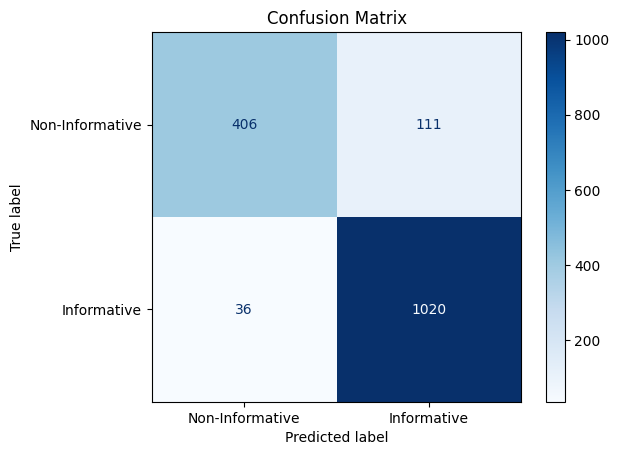

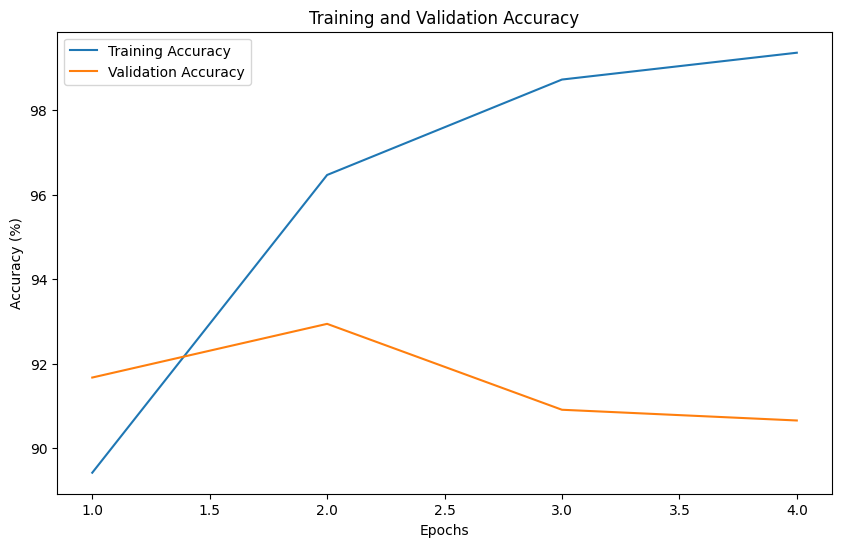

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0  # Convert label to 1 or 0

        # Load image and preprocess
        image = Image.open(image_path).convert("RGB")

        # Process text and image
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        return inputs, torch.tensor(label)

# Define the multimodal classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model):
        super(MultimodalClassifier, self).__init__()
        self.clip_model = clip_model

        # Custom classification layer (1 output logit for binary classification)
        self.classifier = nn.Sequential(
            nn.Linear(clip_model.config.projection_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit for binary classification
        )

    def forward(self, inputs):
        # Extract text and image embeddings separately
        text_embeddings = self.clip_model.get_text_features(inputs['input_ids'].squeeze(1))
        image_embeddings = self.clip_model.get_image_features(inputs['pixel_values'])

        # Concatenate text and image embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)

        # Pass through the custom classifier
        output = self.classifier(combined_embeddings)
        return output

# Load the CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Load the dataset
train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
val_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')

# Filter datasets to include only samples where 'label_text_image' is "Positive"
train_df_positive = train_df[train_df['label_text_image'] == 'Positive']
val_df_positive = val_df[val_df['label_text_image'] == 'Positive']

# Specify image directory
image_dir = ""  # Replace with the correct path to your image directory

# Create datasets and dataloaders with filtered data
train_dataset_positive = MultimodalDataset(train_df_positive, image_dir, processor)
val_dataset_positive = MultimodalDataset(val_df_positive, image_dir, processor)

train_loader_positive = DataLoader(train_dataset_positive, batch_size=32, shuffle=True)
val_loader_positive = DataLoader(val_dataset_positive, batch_size=32, shuffle=False)

# Initialize the model
model = MultimodalClassifier(clip_model)

# Define optimizer and loss function (Binary Cross Entropy Loss)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits

# Training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=4,):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.cuda.amp.GradScaler()

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(1), labels.float())  # Squeeze output to match labels

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()  # Sigmoid for binary classification
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = correct_preds / total_preds * 100
        train_accuracies.append(train_accuracy)

        model.eval()
        val_correct_preds = 0
        val_total_preds = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(inputs)
                predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()

                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = val_correct_preds / val_total_preds * 100
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {running_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Informative", "Informative"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()
    
# Train the model using filtered data
train_model(
    model=model,
    train_loader=train_loader_positive,
    val_loader=val_loader_positive,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=4
)


Testing:   0%|          | 0/48 [00:00<?, ?it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing: 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


Test Accuracy: 92.70%


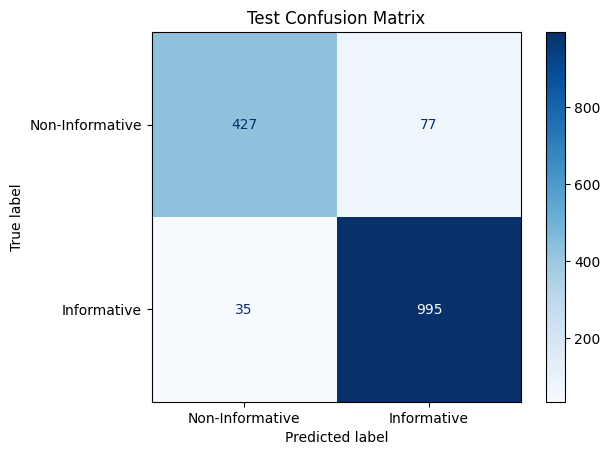

Precision: 92.82%
Recall: 96.60%
F1 Score: 94.67%


In [13]:
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the test dataset
test_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t')

# Filter test dataset to include only samples where 'label_text_image' is "Positive"
test_df_positive = test_df[test_df['label_text_image'] == 'Positive']

# Create the test dataset and dataloader
test_dataset_positive = MultimodalDataset(test_df_positive, image_dir, processor)
test_loader_positive = DataLoader(test_dataset_positive, batch_size=32, shuffle=False)

# Function to test the model
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    test_correct_preds = 0
    test_total_preds = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()

            test_correct_preds += (predicted == labels).sum().item()
            test_total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_accuracy = test_correct_preds / test_total_preds * 100

    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Informative", "Informative"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Test Confusion Matrix")
    plt.show()

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_predictions) * 100
    recall = recall_score(all_labels, all_predictions) * 100
    f1 = f1_score(all_labels, all_predictions) * 100

    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

# Test the model using filtered test data
test_model(model=model, test_loader=test_loader_positive)
